U ovoj svesci je odrađena selekcija i evaluacija modela. Koristiće se tokenizacija ne sekvence kao priprema za model sa pritreniram ugneždavanjem,

In [88]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [92]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Flatten, Dropout, SeparableConv1D, MaxPooling1D
from tensorflow.keras import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import metrics
from keras.callbacks import EarlyStopping

import pickle
from sklearn.utils import class_weight
import time

In [3]:
data = pd.read_csv('data/data_longer.csv')

In [4]:
data.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
data.shape

(223453, 9)

### Podela na trening, test i validacioni skup

In [6]:
# Ovo je prepisano iz prethodne sveske

train_size = 159571 - 96
test_size = 63978
validation_size = int(0.2*train_size)
train_size = train_size - validation_size

train_size, test_size, validation_size

(127580, 63978, 31895)

In [7]:
validation_data = data[:validation_size]
train_data = data[validation_size:train_size+validation_size]
test_data = data[train_size+validation_size : ]

In [8]:
train_data.shape[0], test_data.shape[0], validation_data.shape[0]

(127580, 63978, 31895)

### 1. Tokenizovati tekst u sekvence

Instance će biti podeljene na reči, izdvojiće se neki broj najfrekventnijih reči, a onda će biti pretvorene u vektore reči sekvenci

In [48]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina komentara (broj reci)
max_len = 200

Izdvajaju se pojedinačne reči tj. tokeni zadatog teksta i konstruise se vokabular. 

In [10]:
tokenizer = Tokenizer(num_words=max_features)

In [11]:
tokenizer.fit_on_texts(train_data['comment_text'])

In [14]:
# vokabular:
word_index = tokenizer.word_index

# broj jedinstvenih tokena:
len(word_index)

187048

In [13]:
# cuvanje tokenizera
with open('data/tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

In [15]:
train_sequences = tokenizer.texts_to_sequences(train_data['comment_text'])
X_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len)
y_train = train_data['target']

test_sequences = tokenizer.texts_to_sequences(test_data['comment_text'])
X_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len)
y_test = test_data['target']

validation_sequences = tokenizer.texts_to_sequences(validation_data['comment_text'])
X_validation = preprocessing.sequence.pad_sequences(validation_sequences, maxlen=max_len)
y_validation = validation_data['target']

Sada su podaci pripremljeni za model

### 2. Obučiti mrežu

In [50]:
def create_embedding_matrix(word_index, embedding_dim):
    word_embeddings = {}
    with open('data/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            word_embeddings[word] = coefs
        
        
    embedding_matrix = np.zeros((max_features, embedding_dim))
    for word, i in word_index.items():
        if i >= max_features:
            break
        
        embedding_vector = word_embeddings.get(word)
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

In [51]:
embedding_matrix = create_embedding_matrix(word_index, 100)

In [64]:
def create_cnn_model(num_of_classes, num_of_features, embedding_dim,
                    kernel_size, filters, pool_size, dropout_rate,
                    maxlen, embedding_matrix=None, is_trainable=False):
    
    # za poslednji sloj, u zavisnosti da li je binarna ili viseklasna
    if num_of_classes==2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_of_classes
        
    model = Sequential([
        Embedding(input_dim = num_of_features, 
                 output_dim = embedding_dim,
                 input_length = maxlen,
                 weights = [embedding_matrix],
                 trainable = is_trainable),
        
        Dropout(rate=dropout_rate),
        SeparableConv1D(filters=filters,
                           kernel_size=kernel_size,
                           activation='relu',
                           bias_initializer='random_uniform',
                           depthwise_initializer='random_uniform',
                           padding='same'),
        SeparableConv1D(filters=filters,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'),
        MaxPooling1D(pool_size=pool_size),
        
        SeparableConv1D(filters=filters * 2,
                          kernel_size=kernel_size,
                          activation='relu',
                          bias_initializer='random_uniform',
                          depthwise_initializer='random_uniform',
                          padding='same'),
        
        SeparableConv1D(filters=filters * 2,
                          kernel_size=kernel_size,
                          activation='relu',
                          bias_initializer='random_uniform',
                          depthwise_initializer='random_uniform',
                          padding='same'),
        
        GlobalAveragePooling1D(),
        Dropout(rate=dropout_rate),
        Dense(units, activation=activation)
            
    ])
    
    return model

In [65]:
binary_model = create_cnn_model(2, max_features, 100, kernel_size=3, filters=3, pool_size=3, dropout_rate=0.2, maxlen=max_len,
                                embedding_matrix=embedding_matrix, is_trainable=False)

In [66]:
binary_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 200, 100)          2000000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
separable_conv1d_10 (Separab (None, 200, 3)            603       
_________________________________________________________________
separable_conv1d_11 (Separab (None, 200, 3)            21        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 66, 3)             0         
_________________________________________________________________
separable_conv1d_12 (Separab (None, 66, 6)             33        
_________________________________________________________________
separable_conv1d_13 (Separab (None, 66, 6)           

In [107]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
     # keras.metrics.TrueNegatives(name='tn'),
     # keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [117]:
early_stop = EarlyStopping(monitor='val_recall', patience=5)

In [118]:
binary_model.compile(loss='binary_crossentropy', optimizer=Adam(0.00001), metrics=METRICS)

In [119]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
weights = dict(enumerate(weights))

In [120]:
start = time.time()    

binary_history = binary_model.fit(X_train, y_train, batch_size=64, epochs=50, 
                                  class_weight=weights, validation_data=(X_validation, y_validation), 
                                  callbacks=[early_stop])

print('Trajanje obucavanja: ', time.time() - start)

Epoch 1/50
1994/1994 [==============================] - 58s 29ms/step - loss: 0.3612 - tp: 13546.0000 - fp: 17820.0000 - accuracy: 0.8715 - precision: 0.4319 - recall: 0.8351 - auc: 0.9267 - prc: 0.7259 - val_loss: 0.3033 - val_tp: 2868.0000 - val_fp: 3007.0000 - val_accuracy: 0.8920 - val_precision: 0.4882 - val_recall: 0.8678 - val_auc: 0.9516 - val_prc: 0.8024
Epoch 2/50
1994/1994 [==============================] - 60s 30ms/step - loss: 0.3616 - tp: 10709.0000 - fp: 15238.0000 - accuracy: 0.8633 - precision: 0.4127 - recall: 0.8291 - auc: 0.9197 - prc: 0.7111 - val_loss: 0.3028 - val_tp: 2868.0000 - val_fp: 2996.0000 - val_accuracy: 0.8924 - val_precision: 0.4891 - val_recall: 0.8678 - val_auc: 0.9516 - val_prc: 0.8024
Epoch 3/50
1994/1994 [==============================] - 64s 32ms/step - loss: 0.3606 - tp: 10691.0000 - fp: 14966.0000 - accuracy: 0.8653 - precision: 0.4167 - recall: 0.8277 - auc: 0.9202 - prc: 0.7080 - val_loss: 0.3021 - val_tp: 2868.0000 - val_fp: 2981.0000 - val_

In [132]:
def plot_graphs(history):
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('AUC')
    accuracy = history.history['auc']
    val_accuracy = history.history['val_auc']
    plt.plot(range(0, history.epoch[-1]+1), accuracy, color='red', label='training')
    plt.plot(range(0, history.epoch[-1]+1), val_accuracy, color='orange', label='validation')
    plt.xlabel('epochs')
    plt.legend(loc='best')
    
    plt.subplot(1, 2, 2)
    plt.title('Loss')
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(range(0, history.epoch[-1]+1), loss, color='red', label='training')
    plt.plot(range(0, history.epoch[-1]+1), val_loss, color='orange', label='validation')
    plt.xlabel('epochs')
    plt.legend(loc='best')
    
    plt.show()

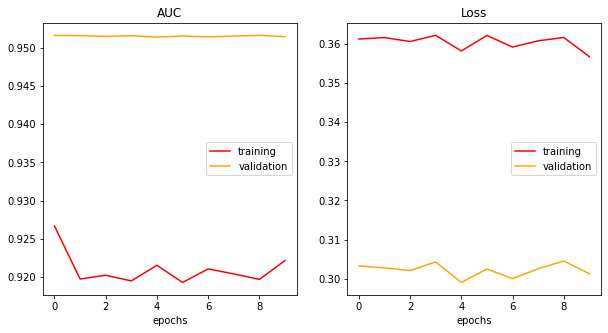

In [133]:
plot_graphs(binary_history)